In [ ]:
#@title Install and Auto restart
import os
root_path=os.getcwd()
# root_path="/content"
base_path=f"{root_path}"

requirements_content = """accelerate==0.30.1
flash_attn==2.5.8
numpy==1.24.4
Pillow==10.1.0
Requests==2.31.0
transformers==4.40.2
gradio==4.29.0
pydub==0.25.1
edge-tts
# gradio==4.15.0
# Pillow==10.3.0
# torch==2.3.0
# torchvision==0.18.0
"""
with open(f"{base_path}/requirements.txt", "w") as file:
    file.write(requirements_content)

print(f"File '{base_path}/requirements.txt' has been successfully created with the specified contents.")

from google.colab import output
# output.eval_js('new Audio("https://github.com/neuralfalcon/Roop-Image-FaceSwap/raw/main/start.mp3").play()')
!pip install -r $base_path/requirements.txt
from IPython.display import clear_output
clear_output()
# output.eval_js('new Audio("https://github.com/neuralfalcon/Roop-Image-FaceSwap/raw/main/install_voice.mp3").play()')
import time
time.sleep(6)
import os
os.kill(os.getpid(), 9)

In [1]:
#@title <-- Play the audio { display-mode: "form" }

%%html
<b>Press play on the music player to keep the tab alive, then run the cell below</b><br/>
<audio src="https://raw.githubusercontent.com/KoboldAI/KoboldAI-Client/main/colab/silence.m4a" controls>

In [2]:
#@title Download /microsoft/Phi-3-vision-128k-instruct
from tqdm import tqdm
import urllib
import os
import shutil
def conditional_download(url, download_file_path):
    print(f"Downloading {os.path.basename(download_file_path)}")
    base_path = os.path.dirname(download_file_path)

    if not os.path.exists(base_path):
        os.makedirs(base_path)

    if os.path.exists(download_file_path):
        os.remove(download_file_path)

    try:
        request = urllib.request.urlopen(url)  # type: ignore[attr-defined]
        total = int(request.headers.get('Content-Length', 0))
    except urllib.error.URLError as e:
        print(f"Error: Unable to open the URL - {url}")
        print(f"Reason: {e.reason}")
        return

    with tqdm(total=total, desc='Downloading', unit='B', unit_scale=True, unit_divisor=1024) as progress:
        try:
            urllib.request.urlretrieve(url, download_file_path, reporthook=lambda count, block_size, total_size: progress.update(block_size))  # type: ignore[attr-defined]
        except urllib.error.URLError as e:
            print(f"Error: Failed to download the file from the URL - {url}")
            print(f"Reason: {e.reason}")
            return

    print(f"Download successful!")
    print(f"URL: {url}")
    print(f"Save at: {download_file_path}")


#set up base_path
import os
root_path=os.getcwd()
# root_path="/content"
base_path=f"{root_path}"



download_dir=f"{base_path}/microsoft/Phi-3-vision-128k-instruct"
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
download_list = [
    "config.json",
    "configuration_phi3_v.py",
    "image_embedding_phi3_v.py",
    "image_processing_phi3_v.py",
    "model.safetensors.index.json",
    "modeling_phi3_v.py",
    "preprocessor_config.json",
    "processing_phi3_v.py",
    "sample_inference.py",
    "special_tokens_map.json",
    "tokenizer.json",
    "tokenizer_config.json",
    "model-00001-of-00002.safetensors",
    "model-00002-of-00002.safetensors"
]
base_url="https://huggingface.co/microsoft/Phi-3-vision-128k-instruct/resolve/main"
for i in download_list:
  file_url=f"{base_url}/{i}"
  download_file_path=f"{download_dir}/{i}"
  conditional_download(file_url, download_file_path)
from IPython.display import clear_output
clear_output()

In [39]:
#@title import /microsoft/Phi-3-vision-128k-instruct
import os
root_path=os.getcwd()
# root_path="/content"
base_path=f"{root_path}"
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
import os
model_id = f"{base_path}/microsoft/Phi-3-vision-128k-instruct"
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto", _attn_implementation="eager")
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [40]:
#@title Main code
temp_image=""
def ask_question(question="What is shown in this image?",user_image=""):
  global temp_image
  if os.path.exists(user_image):
    image = Image.open(user_image)
    temp_image=user_image
  elif os.path.exists(temp_image):
    image = Image.open(temp_image)
  else:
    return "Please upload a image"

  messages = [
      {"role": "user", "content": f"<|image_1|>\n{question}"},
  ]

  prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

  inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

  generation_args = {
      "max_new_tokens": 500,
      "temperature": 0.0,
      "do_sample": False,
  }

  generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

  # remove input tokens
  generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
  response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

  # print(response)
  return response.strip()


import matplotlib.pyplot as plt
from PIL import Image

def display_resized_image(image_path, max_size=(800, 800)):
    """
    Reads an image from the given path, resizes it to fit within the specified max size,
    and displays it using Matplotlib.

    Parameters:
    - image_path: str, path to the image file.
    - max_size: tuple, (width, height) maximum size for the resized image. Default is (800, 800).
    """
    # Load the image
    image = Image.open(image_path)

    # Resize the image to fit within the max_size, maintaining the aspect ratio
    image.thumbnail(max_size, Image.LANCZOS)

    # Display the image using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.show()


In [43]:
import gradio as gr

# Define the Gradio interface for the ask_question function
def ask_question_gradio(question, user_image):
    return ask_question(question=question, user_image=user_image)

# Create the Gradio interface
iface = gr.Interface(
    fn=ask_question_gradio,  # Function that will be called
    inputs=[
        gr.Textbox(lines=2, label="Ask a question"),  # Question input
        gr.Image(type="filepath", label="Upload an image")  # Image input
    ],
    outputs="text",  # The output will be a text (response from the model)
    title="IMAGE SUMMARIZER",
    description="Upload an image and ask a question to generate description around the image."
)

iface.launch(share = true)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://87d00689d97b2bb3cd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.cache/huggingface/modules/transformers_modules/Phi-3-vision-128k-instruct/image_embedding_phi3_v.py:197: UserWarning: Phi-3-V modifies `input_ids` in-place and the tokens indicating images will be removed after model forward. If your workflow requires multiple forward passes on the same `input_ids`, please make a copy of `input_ids` before passing it to the model.
  warnings.warn(


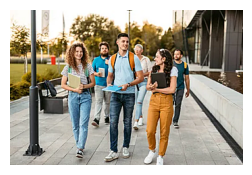

'The image shows a group of six students walking together on a sidewalk. They appear to be engaged in a casual, social walk, possibly after a class or during a break. The students are dressed in casual attire, suitable for a warm day. The environment suggests they are on a college campus, given the presence of a building with large windows in the background and the overall youthful, academic setting. The students are holding books and a backpack, indicating they might be students or involved in some form of study or work. The lighting suggests it is daytime, and the weather appears to be clear and sunny.'

In [41]:
user_image = '/content/image.png'  # @param {type: "string"}
question = ''  # @param {type: "string"}

answer=ask_question(question,user_image)
display_resized_image(user_image)
answer